<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Load-the-results" data-toc-modified-id="Load-the-results-0.0.1">Load the results</a></span></li></ul></li></ul></li><li><span><a href="#3D-plots---BH" data-toc-modified-id="3D-plots---BH-1">3D plots - BH</a></span></li></ul></div>

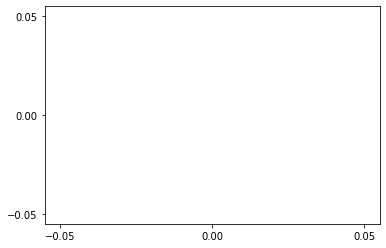

In [1]:
import torch
import seaborn as sns
from src.models import PJPE
import numpy as np
import matplotlib.pyplot as plt
# import pandas as pd
from src.viz.mpl_plots import plot_superimposition, plot_2d, plot_3d
# from src.trainer import project_3d_to_2d
%load_ext autoreload
%autoreload 2

### Load the results

In [2]:
# Get metrics
import os

resume = "absurd-music-3244"
mj = 0
t_data_bh = torch.load(f"{os.getenv('HOME')}/lab/HPE3D/src/results/t_data_{resume}_bh_True_mj_{mj}.pt", map_location='cpu')
t_data_zv = torch.load(f"{os.getenv('HOME')}/lab/HPE3D/src/results/t_data_{resume}_bh_False_mj_{mj}.pt", map_location='cpu')
# t_data_zv = torch.load(f"{os.getenv('HOME')}/lab/HPE3D/src/results/t_data_{resume}_5frame_bh_False_mj_{mj}.pt", map_location='cpu')

pjpe_bh = t_data_bh['bh']
pjpe_zv = t_data_zv['zv']
print(list(t_data_zv.keys()))

['recon_2d', 'recon_3d', 'novel_2d', 'target_2d', 'target_3d', 'z', 'action', 'subject', 'subaction', 'camera', 'recon_3d_org', 'zv']


[INFO]: UMAP reducing  [8694, 51]
[INFO]: Embedding shape  (8694, 2)


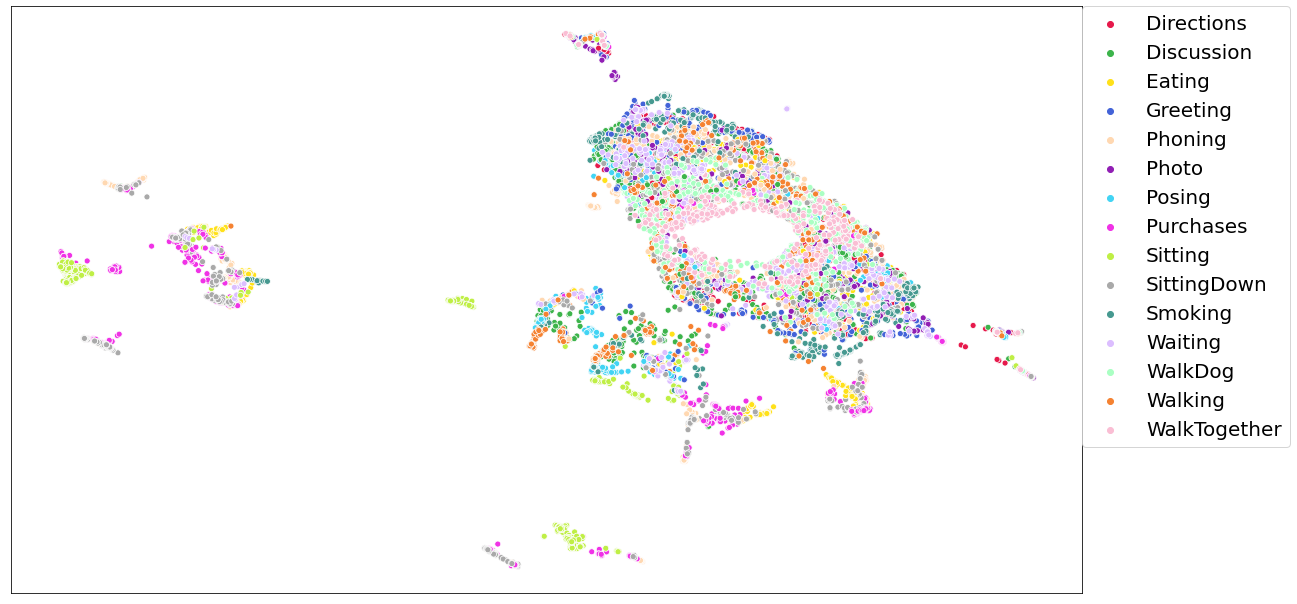

In [25]:
from src.viz.latent_plots import plot_umap
plot_umap(t_data_zv['z'][1::1],t_data_zv['action'][1::1])

torch.Size([87, 51])

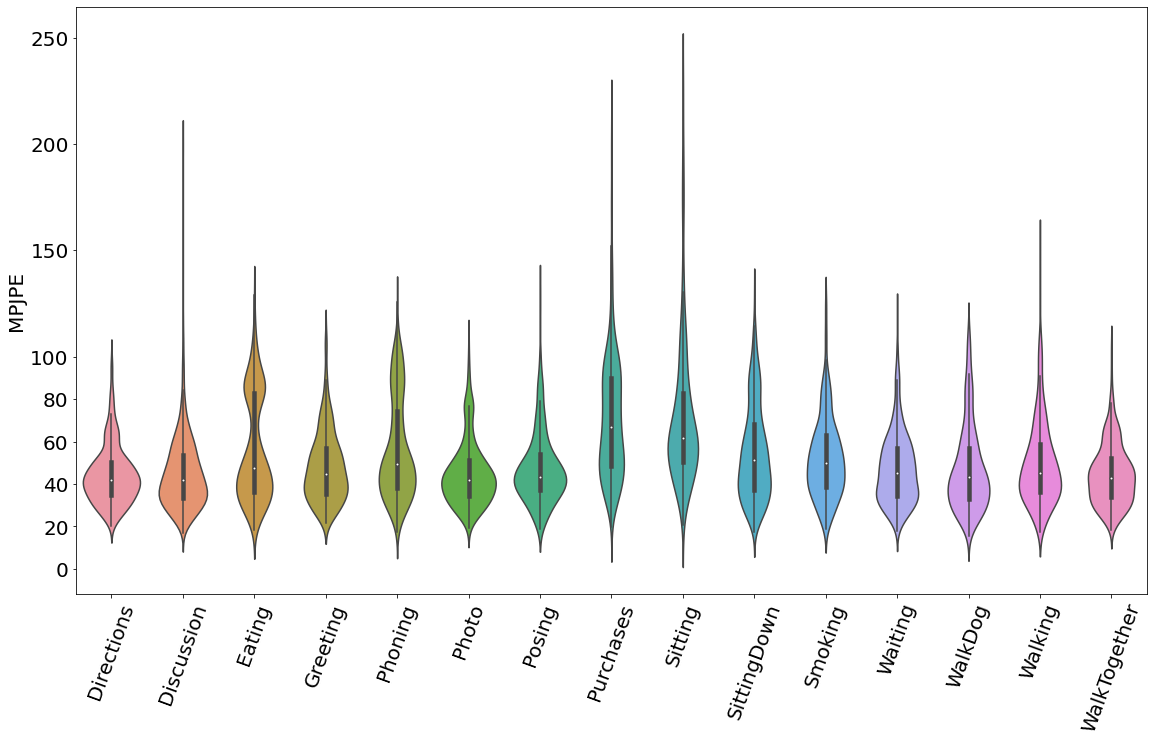

In [23]:
# Get data
fig = plt.figure(figsize=(19.20,10.80))

pjpes = pjpe_zv.cpu().numpy()
actions = t_data_zv['action'].cpu().numpy()
sns.set_palette("pastel")
ax = sns.violinplot(actions, pjpes)

ticks = list(np.arange(100, pjpes.max()+50, 50))
ticks.extend(np.arange(0,100,20))
_ = plt.setp(ax,yticks=sorted(ticks))
#_ = ax.set_xlabel("Actions")

ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=20)
# _ = plt.tight_layout()
_ = ax.set_ylabel("MPJPE", fontsize=20)
_ = plt.xticks(rotation=70)
_ = ax.set_xticklabels(["Directions", "Discussion", "Eating", "Greeting", "Phoning", "Photo", "Posing", "Purchases",
                             "Sitting", "SittingDown", "Smoking", "Waiting", "WalkDog", "Walking", "WalkTogether"])

_ = fig.savefig("../src/results/violin_pjpe.pdf", bbox_inches ='tight',format='pdf', dpi=1200)

In [54]:
# get data close to mean, min or max mpjpe
selections = []
# pjpes = pjpe_zv.cpu().numpy()
actions = t_data_zv['action']
pjpes = PJPE(t_data_zv['recon_3d'], t_data_zv['target_3d'])
pjpes = pjpes.mean(dim=1)
for a in range(2,17):
# for a in range(10,11):# remove    
    ids_a = np.where(actions==a)
    mean_a = pjpes[ids_a].max()
#     sort = pjpes[ids_a].sort(dim=0,descending=True) # remove
#     sort_id = sort[1] < 100
#     print(sort[0][sort_id[0]:10].tolist())
#     print(sort[1][sort_id[0]:10].tolist())
    
#     break
    rel = np.abs(pjpes[ids_a] - mean_a)
    id_close = rel.argmin()
    id = np.where(pjpes == pjpes[ids_a][id_close])
    selections.append(id)
    print(int(id[0]))#, pjpes[ids_a][id_close], a, rel.min(), mean_a)


2878
6130
73047
18120
24801
26722
31669
34930
90950
43450
98756
101351
105002
106047
61221


In [6]:
for a in range(10,11):
    print(a)

10


In [21]:
# plots
%matplotlib notebook
%matplotlib inline
recons = t_data_zv['recon_3d']
targets = t_data_zv['recon_3d']
errors = PJPE(recons, targets).mean(dim=1)

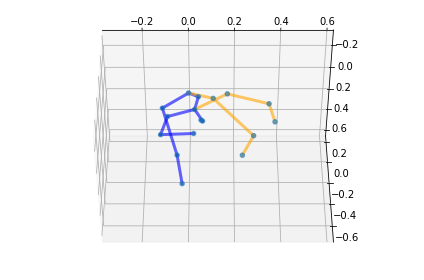

In [22]:
idx = 33987
recon_3d = recons[idx]
target_3d = targets[idx]
error = errors[idx]

recon_3d = 0.6*recon_3d/recon_3d[:,1].max()

_ = plot_3d(recon_3d.cpu().numpy(), show_ticks=True,mode='axis')
plt.show()

In [28]:
import sys
sys.path.append("../../blender-cli-rendering")
from render_pose import render
import os
%load_ext autoreload
%autoreload 2

recons = t_data_zv['recon_3d']
targets = t_data_zv['target_3d']
errors = PJPE(recons, targets).mean(dim=1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
ids = [3493,6422,14027,74176,21621,26692,30089,33987,39416,94650,96348,54005,55495,106863,109473]

#fails
ids = [34930,90950] #,98756,106047]

for idx in ids:
    recon_3d = recons[idx]
    target_3d = targets[idx]
    error = errors[idx]

    scale = 0.1
    resolution = 80
    samplings = 100

    pose = recon_3d
    pose = scale * (pose/pose[:,1].max())
    pose=pose.tolist()

    render(resolution = resolution, samplings=samplings, pose=pose,gt=None, error=None, color=0, out_dir=f"{os.environ['HOME']}/lab/HPE3D/renders/fails_{idx}_pred")

    gt = target_3d
    gt = scale * (gt/gt[:,1].max())
    gt = gt.tolist()

    render(resolution = resolution, samplings=samplings, pose=gt,gt=None, error=None, color=1, out_dir=f"{os.environ['HOME']}/lab/HPE3D/renders/fails_{idx}_gt")

/lhome/sbudara/lab/HPE3D/renders/fails_34930_pred
/lhome/sbudara/lab/HPE3D/renders/fails_34930_gt
/lhome/sbudara/lab/HPE3D/renders/fails_90950_pred
/lhome/sbudara/lab/HPE3D/renders/fails_90950_gt


# 3D plots - BH
%matplotlib notebook

n_recons = torch.stack(t_data_bh['n_recons'])

idx = 6900
for i in range(1):
    pose_3d = n_recons[i, idx, Ellipsis]
    _ = plot_3d(pose_3d.cpu().numpy() ,mode='axis')
plt.show()

In [28]:
recons.shape

torch.Size([8695, 17, 3])

In [ ]:
#### plt.clf()
%matplotlib inline

# reprojection plots
n_recons = torch.stack(t_data_bh['n_recons'])
idx = 6900
T = torch.tensor((0, 0, 10), device=n_recons.device, dtype=n_recons.dtype)

for i in range(20):
    pose_3d = n_recons[i, idx, Ellipsis]
    pose_2d = project_3d_to_2d(pose_3d+T)
    _ = plot_2d(pose_2d.cpu().numpy(), show_ticks=True, mode='axis', background=None)
plt.show()

In [19]:
a = [
        [0,            0,           0],
        [-1.2853e-01,  1.0512e-02, -5.0679e-02],
        [2.7709e-02,  2.5100e-01, -4.0710e-01],
        [1.1463e-02,  6.4020e-01, -1.8854e-01],
        [1.2853e-01, -1.0512e-02,  5.0679e-02],
        [2.5803e-01,  2.2097e-01, -3.2205e-01],
        [1.8305e-01,  6.0340e-01, -1.0381e-01],
        [-1.5258e-02, -2.2694e-01, -3.8681e-02],
        [7.4004e-05, -4.6908e-01, -1.3338e-01],
        [1.4456e-02, -5.1081e-01, -2.3333e-01],
        [2.9278e-03, -6.2335e-01, -2.0242e-01],
        [1.2188e-01, -4.2333e-01, -7.5336e-02],
        [2.8961e-01, -1.9935e-01, -4.9643e-02],
        [2.3501e-01, -1.7183e-01, -2.9430e-01],
        [-1.2729e-01, -4.0671e-01, -1.4703e-01],
        [-2.6958e-01, -1.6512e-01, -1.6593e-01],
        [-1.3282e-01, -8.0722e-02, -3.6027e-01]]
a = torch.tensor(a)

In [42]:
a[0]
a[10]
a[10,1] - a[0,1]
a[:,1].max()
a[:,1].min()

tensor([0., 0., 0.])

tensor([ 0.0029, -0.6234, -0.2024])

tensor(-0.6234)

tensor(0.6402)

tensor(-0.6234)

In [34]:
recon = recon_3d / recon_3d.max()
pose[10,2] - pose[0,2]

tensor([0., 0., 0.])

tensor([ 0.0970, -0.3733, -0.8134])

tensor(-0.8134)

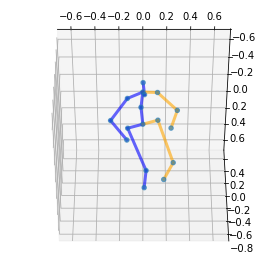

In [43]:
_ = plot_3d(a.cpu().numpy(), show_ticks=True,mode='axis')


In [5]:
import os
path = "../../Thesis/figures/zv_fail/"
for count, filename in enumerate(os.listdir(path)):
    if "pred" in filename:
        src = filename
        des = filename.split('_pred')
        des = des[0]+"_pred.png"
        os.rename(path+src, path+des)

ids = [3493,6422,14027,74176,21621,26692,30089,33987,39416,94650,96348,54005,55495,106863,109473]
rows = 5
cols = 9
path = "../../Thesis/figures/zv_mean/"
for id in ids:
    ax = plt.add_subplot(rows, cols, i)
    ax.imshow()